In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
# Dataset URL: https://raw.githubusercontent.com/beoutbreakprepared/nCoV2019/master/latest_data/latestdata.csv

In [3]:
train = pd.read_csv("covid2train.csv", index_col = 0)

In [4]:
def clean(train):
    features = ['age', 'sex', 'country', 'chronic_disease_binary', 'que_paso']
    xtrain = train[features]

# Dropping NA's from only 'sex' + 'country'    
    subset = xtrain.dropna(subset = ['age','sex','country'])
    countries = xtrain['country'].drop_duplicates().dropna()

# Replacing the age ranges with their means    
    mp = {'20-29': np.mean([20,29]), '40-49': np.mean([40,49]),'50-59': np.mean([50,59]),
          '60-69': np.mean([60,69]), '70-79': np.mean([70,79]),
          '80-89': np.mean([80,89]),'90-99': np.mean([90,99]), '80-': 80}
    
# Dictionary replacing countries with numerical values
    mp2 = {}
    key = np.arange(len(countries) + 1)
    for i,j in zip(countries,key):
        val = {i:j}
        mp2.update(val)
        
    mp3 = {'male': 0, 'female': 1}
        
# Updating the training data with new values
    subset = subset.replace(mp).replace(mp2).replace(mp3)
    subset['chronic_disease_binary'] = subset['chronic_disease_binary']*1
    subset['age'] = subset['age'].astype(float)
    
    xtrain = subset
    ytrain = subset['que_paso']
    return xtrain, ytrain, mp2

In [5]:
xtrain, ytrain, mp2 = clean(train)

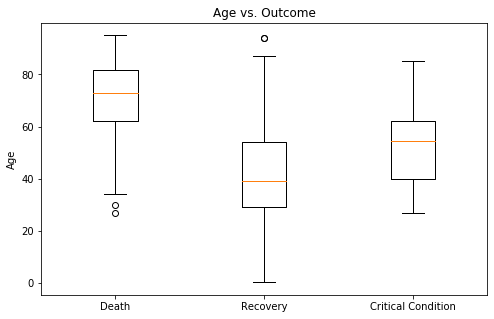

In [6]:
age_death = xtrain['que_paso'] == 0
age_rec = xtrain['que_paso'] == 1
age_ill = xtrain['que_paso'] == 2

xdeath = xtrain[age_death]
xrec = xtrain[age_rec]
x_ill = xtrain[age_ill]

age1 = xdeath['age']
age2 = xrec['age']
age3 = x_ill['age']

data = [age1, age2, age3]
fig, ax = plt.subplots(figsize = (8,5))
ax.set_title('Age vs. Outcome')

ax.boxplot(data, labels = ['Death', 'Recovery', 'Critical Condition'])
ax.set_ylabel("Age")
plt.show()

In [7]:
xtrain = xtrain.drop('que_paso', axis = 1)

In [8]:
from sklearn.ensemble import RandomForestClassifier 

clf =  RandomForestClassifier(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True, random_state=42)

clf.fit(xtrain, ytrain)

var_imp = clf.feature_importances_
var = xtrain.columns

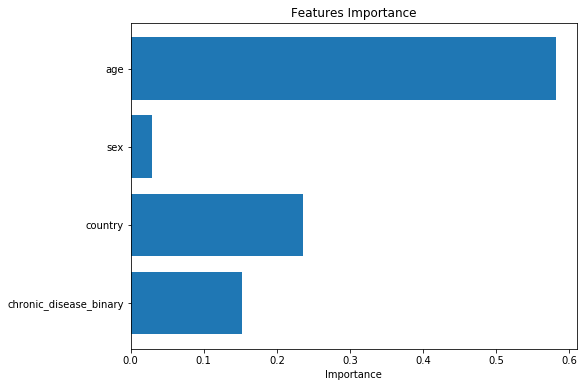

In [9]:
fig, ax = plt.subplots(figsize = (8,6))

y_pos = np.arange(len(var))

ax.barh(y_pos, var_imp, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(var)
ax.invert_yaxis() 
ax.set_xlabel('Importance')
ax.set_title('Features Importance')

plt.show()

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics

cv_xtrain, cv_xtest, cv_ytrain, cv_ytest = train_test_split(xtrain, ytrain, test_size = 0.5)


clf =  RandomForestClassifier(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True, random_state=42)

clf.fit(cv_xtrain, cv_ytrain)
ypred = clf.predict(cv_xtest)

print("The accuracy for Random Forest is",round(accuracy_score(ypred, cv_ytest),3))

The accuracy for Random Forest is 0.89


In [11]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler

clf2 = MultinomialNB()
clf2.fit(cv_xtrain, cv_ytrain)

NB_ypred = clf2.predict(cv_xtest)
print("The accuracy for Multinomial Naive Bayes is", round(accuracy_score(NB_ypred, cv_ytest),3))

The accuracy for Multinomial Naive Bayes is 0.499


In [12]:
from sklearn.ensemble import AdaBoostClassifier

clf3 = AdaBoostClassifier()
clf3.fit(cv_xtrain, cv_ytrain)

AB_ypred = clf3.predict(cv_xtest)

print("The accuracy for AdaBoost Classifier is", round(accuracy_score(AB_ypred, cv_ytest),3))

The accuracy for AdaBoost Classifier is 0.828


In [13]:
from sklearn.svm import SVC

clf4 = SVC(gamma = 'auto')
clf4.fit(cv_xtrain, cv_ytrain)

SVM_ypred = clf4.predict(cv_xtest)

print("The accuracy for SVM Classifier is", round(accuracy_score(SVM_ypred, cv_ytest),3))

The accuracy for SVM Classifier is 0.843


In [14]:
from sklearn.neighbors import KNeighborsClassifier as knc

def best_k(xtrain,ytrain,xtest,ytest):
    krange = range(1,25) # 24 possible k's
    scores = []
    for k in krange:
        knn = knc(n_neighbors = k)
        knn.fit(xtrain,ytrain)
        ypred = knn.predict(xtest)
        scores.append(metrics.accuracy_score(ytest,ypred))
    i = np.argmax(scores)
    return krange[i]

def knn(xtrain,ytrain,xtest,k):
    scaler = StandardScaler()
    scaler.fit(xtrain)
    scaler.fit(xtest)
    xtrain = scaler.transform(xtrain)
    xtest = scaler.transform(xtest)
    
    knn_class_tr = knc(n_neighbors = k).fit(xtrain, ytrain)
    y_pred = knn_class_tr.predict(xtest)
    return y_pred

k = best_k(cv_xtrain, cv_ytrain, cv_xtest, cv_ytest)
KNN_ypred = knn(cv_xtrain, cv_ytrain, cv_xtest, k)
print("The accuracy for KNN Classifier is", round(accuracy_score(KNN_ypred, cv_ytest), 3))

The accuracy for KNN Classifier is 0.858
